## 5.2 共享單車需求預測（迴歸）

### 共通事前處理

In [1]:
# 取得中文字型
!wget 'https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf'

--2021-11-29 09:20:02--  https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf [following]
--2021-11-29 09:20:02--  https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2021-11-29 09:20:02 

In [2]:
# 共通事前處理

# 隱藏不必要的警告
import warnings
warnings.filterwarnings('ignore')

# 匯入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 將字型新增到 matplotlib
fm.fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')

# 用來顯示資料框的函式
from IPython.display import display

# 調整顯示選項
# NumPy 的浮點數表示精度
np.set_printoptions(suppress=True, precision=4)

# pandas 中的浮點數表示精度
pd.options.display.float_format = '{:.4f}'.format

# 顯示資料框中的所有項目
pd.set_option("display.max_columns",None)

# 指定圖形的預設字體大小
plt.rcParams["font.size"] = 14

# 指定圖形的預設字型
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'

# 隨機種子
random_seed = 123

原始連結   
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

#### 資料項目備忘錄

instant　索引  
dteday　日期　（yy-mm-dd）  
season　季節　（1: 冬 2: 春 3: 夏 4: 秋）  
yr　年份　（0: 2011, 1:2012）  
mnth　月份 （1 - 12）  
hr　小時 （0 - 23）  
holiday　國定假日  
weekday　星期幾　（0 - 6）  
workingday　工作日　（1: 工作日 0: 假日）  
weathersit　天氣　（1: 晴到多雲 2: 有霧 3: 小雨 4: 大雨）  
temp　氣溫 （已標準化）  
atemp　體感溫度　（已標準化）  
hum　濕度　（已標準化）  
windspeed　風速　（已標準化）  
casual　臨時用戶租借量  
registered　註冊用戶租借量  
cnt　整體用戶租借量  

### 5.2.4 從載入資料到確認資料

#### 載入資料

In [3]:
# 下載網址
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 下載並解壓縮公共資料集
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

--2021-11-29 09:20:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.05MB/s    in 0.3s    

2021-11-29 09:20:03 (1.05 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

  inflating: hour.csv                


In [4]:
# 確認資料狀態
!head -5 day.csv

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562


In [5]:
# 將 day.csv 匯入資料框
# 利用 parse_dates 指定日期所在的行
df = pd.read_csv('day.csv', parse_dates=[1])

# 確認資料屬性
print(df.dtypes)

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


In [6]:
# instant 為連號，預測不需使用，因此刪除
df = df.drop('instant', axis=1)

# 項目名稱中文化

columns = [
    '日期',  '季節',  '年份', '月份', '國定假日', '星期幾', '工作日', '天氣', 
    '氣溫', '體感溫度',  '濕度', '風速',
    '臨時用戶租借量', '註冊用戶租借量', '整體用戶租借量'
]

# 將項目名稱替換成中文
df.columns = columns

#### 確認資料

In [7]:
# 確認開頭 5 列
display(df.head())

# 確認結尾 5 列
display(df.tail())

,日期,季節,年份,月份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速,臨時用戶租借量,註冊用戶租借量,整體用戶租借量
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日期,季節,年份,月份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速,臨時用戶租借量,註冊用戶租借量,整體用戶租借量
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


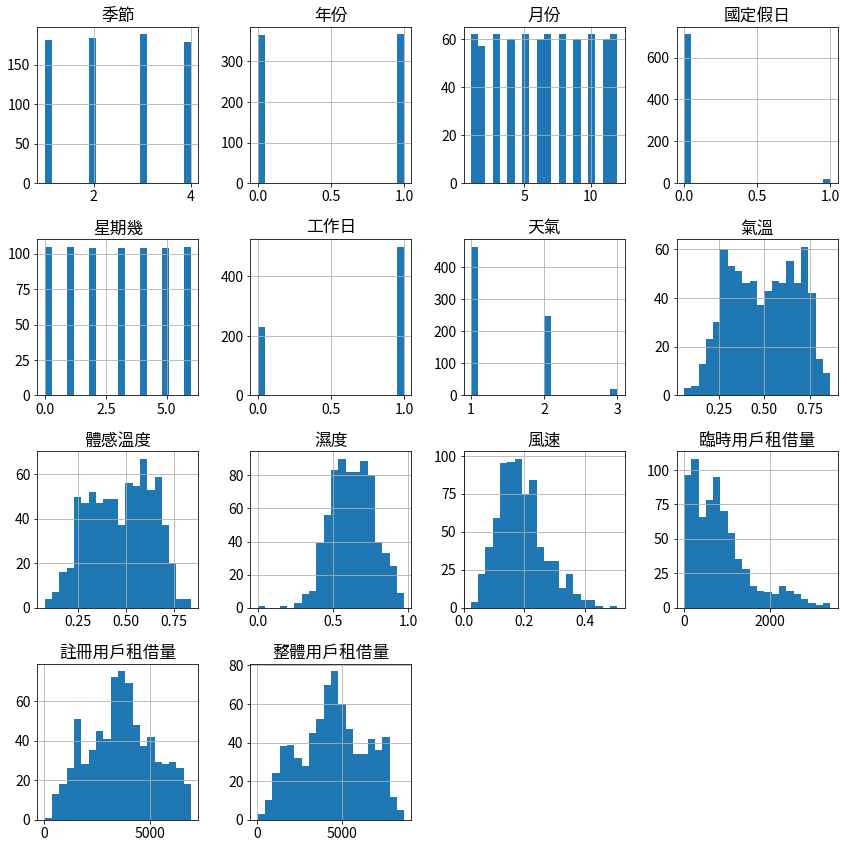

In [8]:
# 繪製次數分佈圖

# 用來調整圖形大小的咒語
from pylab import rcParams
rcParams['figure.figsize'] = (12, 12)

# 繪製資料框中數值欄位的直方圖
df.hist(bins=20)
plt.tight_layout()
plt.show()

In [9]:
# 確認缺失值
df.isnull().sum()

日期         0
季節         0
年份         0
月份         0
國定假日       0
星期幾        0
工作日        0
天氣         0
氣溫         0
體感溫度       0
濕度         0
風速         0
臨時用戶租借量    0
註冊用戶租借量    0
整體用戶租借量    0
dtype: int64

#### 繪製時間序列資料的圖形

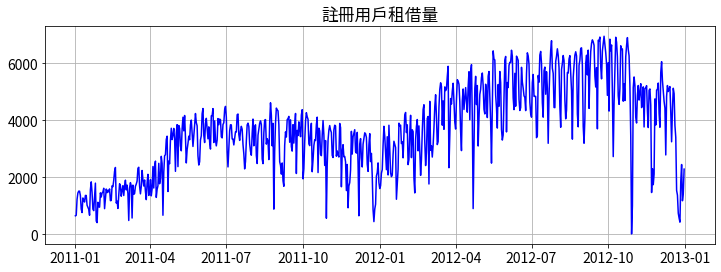

In [10]:
# 繪製時間序列圖（註冊用戶租借量）
plt.figure(figsize=(12,4))

# 繪製圖形
plt.plot(df['日期'],df['註冊用戶租借量'],c='b')

# 顯示網格等
plt.grid()
plt.title('註冊用戶租借量')

# 輸出畫面
plt.show()

### 5.2.5 預處理資料與分割資料

#### 預處理資料
（不需要）

#### 資料分割

策略
* 將目標變數 y 設定為「註冊用戶租借量」
* 將「整體用戶租借量」與「臨時整體用戶租借量」從資料中刪除
* 由於不需以日期為輸入變數，因此將其從輸入變數 x 中刪除
* 時間軸則設定以 2012-11-01 之前為訓練資料，之後為驗證資料

In [11]:
# 分割成 x, y
x = df.drop(['日期', '臨時用戶租借量', '註冊用戶租借量',
    '整體用戶租借量'], axis=1)
y = df['註冊用戶租借量'].values

In [12]:
# 設定分割日 mday
mday = pd.to_datetime('2012-11-1')

# 建立訓練用 index 與驗證用 index
train_index = df['日期'] < mday
test_index = df['日期'] >= mday

# 分割輸入資料
x_train = x[train_index]
x_test = x[test_index]

# y 也進行分割
y_train = y[train_index]
y_test = y[test_index]

# 分割日期資料（用於繪製圖形）
dates_test = df['日期'][test_index]

In [13]:
# 確認結果（確認大小）
print(x_train.shape)
print(x_test.shape)

# 確認結果（關注邊界值）
display(x_train.tail())
display(x_test.head())

(670, 11)
(61, 11)


,季節,年份,月份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速
665,4,1,10,0,6,0,2,0.5300,0.5151,0.7200,0.2357
666,4,1,10,0,0,0,2,0.4775,0.4678,0.6946,0.3980
667,4,1,10,0,1,1,3,0.4400,0.4394,0.8800,0.3582
668,4,1,10,0,2,1,2,0.3182,0.3099,0.8255,0.2130
669,4,1,10,0,3,1,2,0.3575,0.3611,0.6667,0.1667


,季節,年份,月份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速
670,4,1,11,0,4,1,2,0.3658,0.3699,0.5817,0.1573
671,4,1,11,0,5,1,1,0.3550,0.3560,0.5221,0.2662
672,4,1,11,0,6,0,2,0.3433,0.3238,0.4913,0.2705
673,4,1,11,0,0,0,1,0.3258,0.3295,0.5329,0.1791
674,4,1,11,0,1,1,1,0.3192,0.3081,0.4942,0.2363


In [14]:
# 確認目標變數的分割結果
print(y_train[:10])

[ 654  670 1229 1454 1518 1518 1362  891  768 1280]


### 5.2.6 選擇演算法

#### 選擇演算法

In [15]:
# 選擇演算法
# 選擇 XGBRegressor
from xgboost import XGBRegressor
algorithm = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

### 5.2.7 訓練與預測

In [16]:
# 註冊用戶租借量預測模型的訓練與預測

# 訓練
algorithm.fit(x_train, y_train)

# 預測
y_pred = algorithm.predict(x_test)

# 確認預測結果
print(y_pred[:5])

[4613.577  4863.4756 4057.923  3642.1284 4354.408 ]


### 5.2.8 評估

In [17]:
# 評估（註冊用戶租借量）

# 呼叫 score 函式
score = algorithm.score(x_test, y_test)

# 計算 R2 值
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_pred)

# 確認結果
print(f'score: {score:.4f}  r2_ score: {r2_score:.4f}')

score: 0.5294  r2_ score: 0.5294


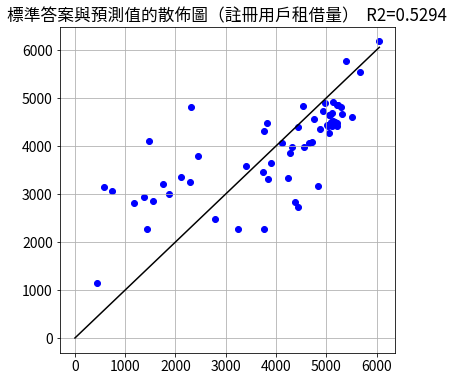

In [18]:
# 以散佈圖比較標準答案與預測值（註冊用戶租借量）
plt.figure(figsize=(6,6))
y_max = y_test.max()
plt.plot((0,y_max), (0, y_max), c='k')
plt.scatter(y_test, y_pred, c='b')
plt.title(f'標準答案與預測值的散佈圖（註冊用戶租借量）\
  R2={score:.4f}')
plt.grid()
plt.show()

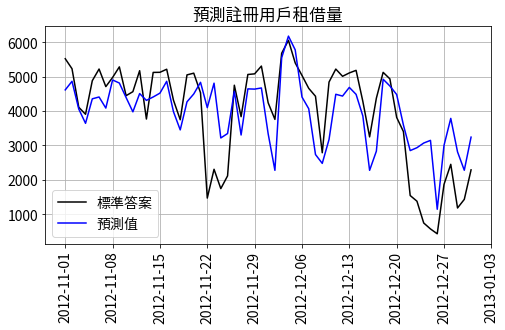

In [19]:
# 繪製時間序列圖（註冊用戶租借量）
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 繪製圖形
ax.plot(dates_test, y_test, label='標準答案', c='k')
ax.plot(dates_test, y_pred, label='預測值', c='b')

# 日期刻度間隔
# 於每週四顯示日期
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 將日期刻度標籤文字旋轉 90 度
ax.tick_params(axis='x', rotation=90)

# 顯示網格等
ax.grid()
ax.legend()
ax.set_title('預測註冊用戶租借量')

# 輸出畫面
plt.show()

### 5.2.9 調整

In [20]:
# 用於對項目進行 One-Hot 編碼之函式
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column],axis=1),df_dummy],axis=1)
    return df

# 對「月份」與「季節」進行 One-Hot 編碼

x2 = x.copy()
x2 = enc(x2, '月份')
x2 = enc(x2, '季節')

# 確認結果
display(x2.head())

,年份,國定假日,星期幾,工作日,天氣,氣溫,體感溫度,濕度,風速,月份_1,月份_2,月份_3,月份_4,月份_5,月份_6,月份_7,月份_8,月份_9,月份_10,月份_11,月份_12,季節_1,季節_2,季節_3,季節_4
0,0,0,6,0,2,0.3442,0.3636,0.8058,0.1604,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,2,0.3635,0.3537,0.6961,0.2485,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,1,0.1964,0.1894,0.4373,0.2483,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,2,1,1,0.2000,0.2121,0.5904,0.1603,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,3,1,1,0.2270,0.2293,0.4370,0.1869,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [21]:
# 註冊用戶模型（調整後）

# 以 mday 為基準分割輸入資料
x2_train = x2[train_index]
x2_test = x2[test_index]

#　選擇演算法
algorithm2 = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

# 訓練
algorithm2.fit(x2_train, y_train)

# 預測
y_pred2 = algorithm2.predict(x2_test)

# 確認預測結果
print(y_pred2[:5])

[4509.6143 4841.9644 3852.8997 3567.8196 4280.041 ]


In [22]:
# 評估（註冊用戶）（調整後）

# 呼叫 score 函式
score2 = algorithm2.score(x2_test, y_test)

# 確認結果
print(f'score: {score2:.4f}')

score: 0.6182


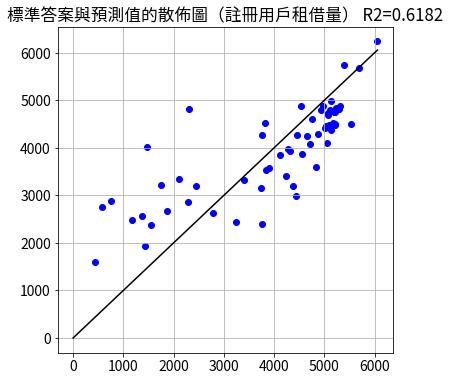

In [23]:
# 利用散佈圖比較標準答案與預測值（註冊用戶）
plt.figure(figsize=(6,6))
y_max = y_test.max()
plt.plot((0,y_max), (0, y_max), c='k')
plt.scatter(y_test, y_pred2, c='b')
plt.title(f'標準答案與預測值的散佈圖（註冊用戶租借量） R2={score2:.4f}')
plt.grid()
plt.show()

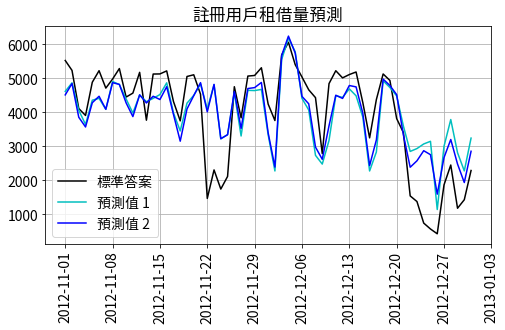

In [24]:
# 繪製時間序列圖（調整後 註冊用戶租借量）
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# 繪製圖形
ax.plot(dates_test, y_test, label='標準答案', c='k')
ax.plot(dates_test, y_pred, label='預測值 1', c='c')
ax.plot(dates_test, y_pred2, label='預測值 2', c='b')

# 日期刻度間隔
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日期格式
ax.tick_params(axis='x', rotation=90)

# 顯示網格等
ax.grid()
ax.legend()
ax.set_title('註冊用戶租借量預測')

# 輸出畫面
plt.show()

### 5.2.10 重要性分析

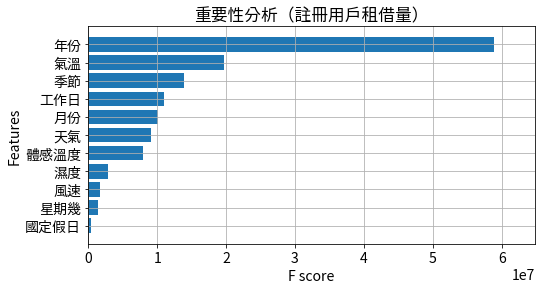

In [25]:
# 對註冊用戶租借量進行重要性分析
import xgboost as xgb
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(algorithm, ax=ax, height=0.8,
    importance_type='gain', show_values=False,
    title='重要性分析（註冊用戶租借量）')
plt.show()